# Binary classification Model

### train / test split

In [366]:
import numpy as np
import torch
from torch import nn
from sympy import false

X_train = np.loadtxt("../../datasets/merged/X_train_imputed_scaled.csv", delimiter=",", skiprows=1)
X_test = np.loadtxt("../../datasets/merged/X_test_imputed_scaled.csv", delimiter=",", skiprows=1)
y_train = np.loadtxt("../../datasets/merged/y_train.csv", delimiter=",", skiprows=1)
y_test = np.loadtxt("../../datasets/merged/y_test.csv", delimiter=",", skiprows=1)

X_train = np.delete(X_train, 0, axis=1)
X_test = np.delete(X_test, 0, axis=1)
y_train = np.delete(y_train, 0, axis=1)
y_test = np.delete(y_test, 0, axis=1)

X_train = torch.from_numpy(X_train).type(torch.float32).squeeze()
X_test = torch.from_numpy(X_test).type(torch.float32).squeeze()
y_train = torch.from_numpy(y_train).type(torch.float32).squeeze()
y_test = torch.from_numpy(y_test).type(torch.float32).squeeze()


In [367]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10018, 7]),
 torch.Size([2648, 7]),
 torch.Size([10018]),
 torch.Size([2648]))

In [368]:
type(X_train), X_train.dtype

(torch.Tensor, torch.float32)

In [369]:
type(y_train), y_train.dtype

(torch.Tensor, torch.float32)

In [370]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [371]:
torch.cuda.is_available()

True

### Construct Model Class

In [372]:
class ExoplanetsV0(nn.Module):

    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.hidden_units = hidden_units
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(in_features=int(hidden_units/2), out_features=int(hidden_units / 4)),
            nn.ReLU(),
            nn.Linear(in_features=int(hidden_units/4), out_features=output_features),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Create a test model
test = ExoplanetsV0(input_features=X_test.shape[1], output_features=1, hidden_units=32).to(device)
print(test, test.input_features, test.output_features, test.hidden_units)
del test

ExoplanetsV0(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
) 7 1 32


In [373]:
X_train.shape, y_train.shape

(torch.Size([10018, 7]), torch.Size([10018]))

### Loss Function and Optimizer

In [374]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train Model

Model outputs are raw **Logits**

We are converting logits into prediction probabilities by passing them to some kind of activation function (int this case `nn.Sigmoid()`) Then we can convert our model's prediction probabilities to **prediction labels** by taking the `argmaX_scaled()`

# Tracking Accuracy

In [375]:
import matplotlib.pyplot as plt

def makePlots(track_accuracy, track_loss, track_f1, track_precision, track_recall, track_auc,
              track_test_accuracy, track_test_loss, track_test_f1, track_test_precision,
              track_test_recall, track_test_auc):
    epoch_range = range(1, epochs + 1)

    plt.figure(figsize=(18, 12))

    # Accuracy
    plt.subplot(3, 2, 1)
    plt.plot(epoch_range, track_accuracy, label='Train Accuracy')
    plt.plot(epoch_range, track_test_accuracy, label='Test Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(3, 2, 2)
    plt.plot(epoch_range, track_loss, label='Train Loss')
    plt.plot(epoch_range, track_test_loss, label='Test Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # F1 Score
    plt.subplot(3, 2, 3)
    plt.plot(epoch_range, track_f1, label='Train F1')
    plt.plot(epoch_range, track_test_f1, label='Test F1')
    plt.title('F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Precision
    plt.subplot(3, 2, 4)
    plt.plot(epoch_range, track_precision, label='Train Precision')
    plt.plot(epoch_range, track_test_precision, label='Test Precision')
    plt.title('Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid(True)

    # Recall
    plt.subplot(3, 2, 5)
    plt.plot(epoch_range, track_recall, label='Train Recall')
    plt.plot(epoch_range, track_test_recall, label='Test Recall')
    plt.title('Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid(True)

    # AUC
    plt.subplot(3, 2, 6)
    plt.plot(epoch_range, track_auc, label='Train AUC')
    plt.plot(epoch_range, track_test_auc, label='Test AUC')
    plt.title('AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=300)  # Zapisuje wykres w wysokiej jakości
    plt.show()


### Building a training loop and testing loop

In [376]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
epochs = 2500

def trainModel(model, X_train, y_train, X_test, y_test, isCrossValidation=False):

    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    eps = 0.00001

    # Set the number of epochs

    # Tracking loss and accuracy
    track_accuracy = []
    track_loss = []
    track_f1 = []
    track_precision = []
    track_recall = []
    track_auc = []

    track_test_f1 = []
    track_test_precision = []
    track_test_recall = []
    track_test_auc = []
    track_test_accuracy = []
    track_test_loss = []


    # Put data to target device
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    weight_for_0 = len(y_test) + len(y_train) / (2 * ((y_test < eps).sum() + (y_train < eps).sum()))
    weight_for_1 = len(y_test) + len(y_train) / (2 * ((y_test - 1 < eps).sum() + (y_train - 1 < eps).sum()))

    pos_weight = torch.tensor([weight_for_1 / weight_for_0]).to(device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)


    for epoch in range(epochs):
        ### Training
        model.train()

        # 1. Forward pass
        y_logits = model(X_train).squeeze()
        y_probs = torch.sigmoid(y_logits)
        y_pred = torch.round(y_probs)  # turn logits into pred probs and into pred labels

        # 2. Calculate the loss / cost
        loss = loss_fn(y_logits, y_train)
        track_loss.append(loss.item())

        acc = accuracy_fn(y_true=y_train.detach(), y_pred=y_pred.detach())
        precision = precision_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
        recall = recall_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
        f1 = f1_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
        auc = roc_auc_score(y_true=y_train.detach().cpu(), y_score=y_probs.detach().cpu())

        track_accuracy.append(acc)
        track_precision.append(precision)
        track_recall.append(recall)
        track_f1.append(f1)
        track_auc.append(auc)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backpropagation algorithm
        loss.backward()

        # 5. Gradient descent algorithm
        optimizer.step()

        ### Testing
        model.eval()
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze()       # logits
            test_probs = torch.sigmoid(test_logits)     # Probability
            test_pred = torch.round(test_probs)         # 1 or 0

            # 2. Calculate test loss/acc

            test_loss = loss_fn(test_logits, y_test)
            track_test_loss.append(test_loss.item())

            test_acc = accuracy_fn(y_true=y_test.cpu(), y_pred=test_pred.cpu())
            test_precision = precision_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
            test_recall = recall_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
            test_f1 = f1_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
            test_auc = roc_auc_score(y_true=y_test.cpu(), y_score=test_probs.cpu())
            track_test_auc.append(test_auc)

            track_test_accuracy.append(test_acc)
            track_test_precision.append(test_precision)
            track_test_recall.append(test_recall)
            track_test_f1.append(test_f1)

        # Print out what's happenin'
        if not isCrossValidation and (epoch % 500 == 0 or epoch == epochs - 1):
            print(
                f"Epoch {epoch} \n"
                f" loss: {loss:.5f} | accuracy: {acc:.2f}% | Precision: {precision:.2f}% | Recall: {recall:.2f}% | f1: {f1:.2f}% | auc: {auc:.2f} \n"
                f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% | Test precision: {test_precision:.2f}% | Test recall: {test_recall:.2f}% | Test f1: {test_f1:.2f}% | Test auc: {test_auc:.2f} \n")

    if not isCrossValidation:
        makePlots(track_accuracy, track_loss, track_f1, track_precision, track_recall, track_auc,
                  track_test_accuracy, track_test_loss, track_test_f1, track_test_precision,
                  track_test_recall, track_test_auc)
    return test_acc


# Cross-validation

Accuracy: 72.26
Accuracy: 71.21
Accuracy: 70.56
Accuracy: 69.90
Accuracy: 68.45
Stats (cross validation): 70.47% (+/- 1.28%)
Epoch 0 
 loss: 0.69735 | accuracy: 51.61% | Precision: 28.57% | Recall: 0.04% | f1: 0.08% | auc: 0.46 
Test loss: 0.70887 | Test accuracy: 47.09% | Test precision: 0.00% | Test recall: 0.00% | Test f1: 0.00% | Test auc: 0.42 

Epoch 500 
 loss: 0.68727 | accuracy: 51.59% | Precision: 36.84% | Recall: 0.14% | f1: 0.29% | auc: 0.68 
Test loss: 0.69184 | Test accuracy: 46.98% | Test precision: 0.00% | Test recall: 0.00% | Test f1: 0.00% | Test auc: 0.66 

Epoch 1000 
 loss: 0.67702 | accuracy: 58.25% | Precision: 65.13% | Recall: 29.41% | f1: 40.52% | auc: 0.70 
Test loss: 0.67998 | Test accuracy: 54.68% | Test precision: 68.12% | Test recall: 26.73% | Test f1: 38.40% | Test auc: 0.70 

Epoch 1500 
 loss: 0.65527 | accuracy: 62.90% | Precision: 63.62% | Recall: 54.39% | f1: 58.64% | auc: 0.72 
Test loss: 0.65701 | Test accuracy: 61.63% | Test precision: 68.40% | Te

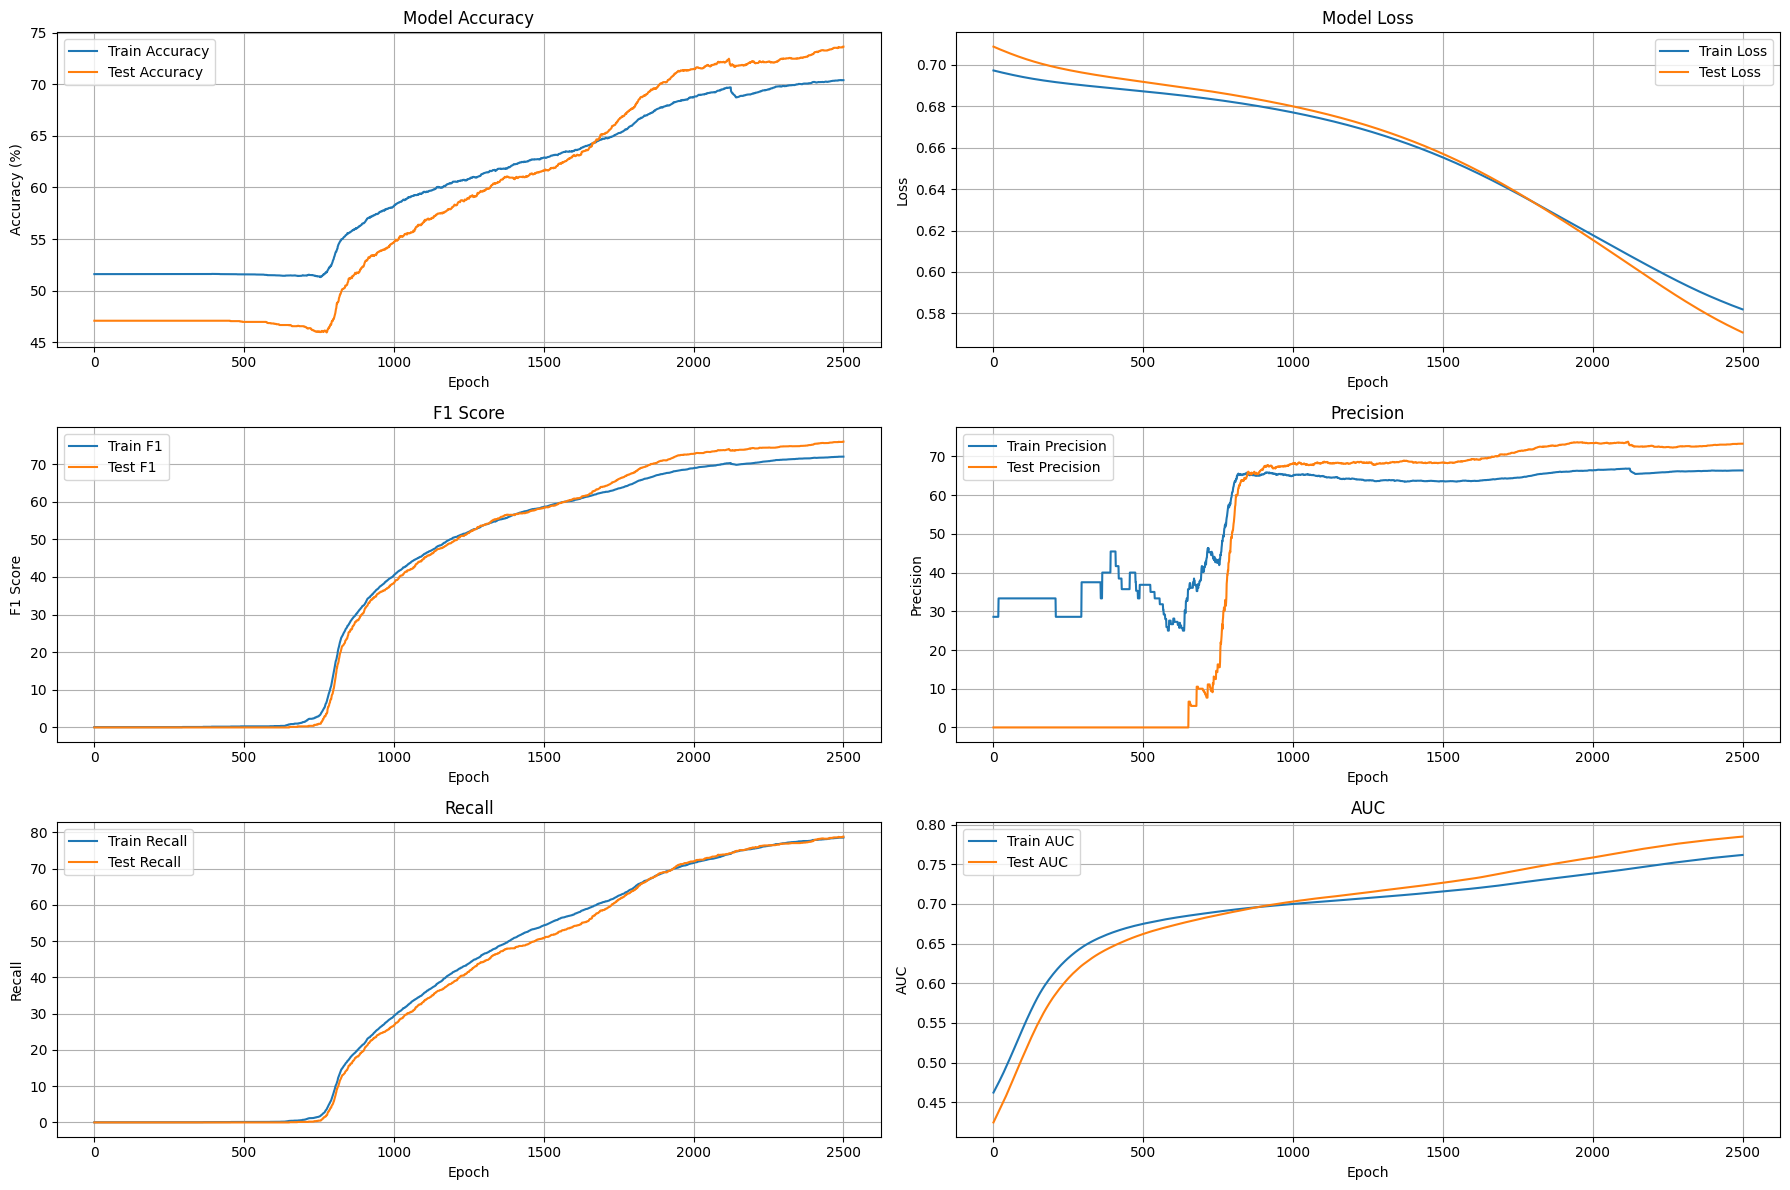

73.64048338368579

In [377]:
from sklearn.model_selection import StratifiedKFold, train_test_split

kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model_1 = ExoplanetsV0(input_features=X_test.shape[1], output_features=1, hidden_units=32).to(device)
    acc = trainModel(model_1, X_train[train], y_train[train], X_train[test], y_train[test], True)
    print("Accuracy: %.2f" % acc)
    cv_scores.append(acc)

# evaluate the model
model_acc = np.mean(cv_scores)
model_std = np.std(cv_scores)
print("Stats (cross validation): %.2f%% (+/- %.2f%%)" % (model_acc, model_std))

model_1 = ExoplanetsV0(input_features=X_test.shape[1], output_features=1, hidden_units=32).to(device)
trainModel(model_1, X_train, y_train, X_test, y_test, false)

# Saving and loading already trained Model

Creating template / method for effective saving already trained model, so user don't have to wait for it to finish training before usage.

In [403]:
from pathlib import Path

MODEL_PATH = Path("../../saved-models/nn")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

def SaveModel(model, model_name: str):
    # 1. Create models directory if it doesn't exist yet

    # 2. Create model save path
    MODEL_NAME = model_name + ".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # 3. Save the model state dict
    save = [model.state_dict(), model.input_features, model.output_features, model.hidden_units]
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj = save,
               f = MODEL_SAVE_PATH)
SaveModel(model_1, "nn_exoplanets0")

Saving model to: ../../saved-models/nn/nn_exoplanets0.pth


In [386]:
!ls -l ../../saved-models

total 4
drwxrwxr-x 2 hubert hubert 4096 Oct  5 00:23 nn


### Loading Trained model



In [7]:
import torch
# To load in a saved state_dict we have to instantiate a new instace of our model class
def load_model(model_name):
    model_name += ".pth"
    load = torch.load(f = MODEL_PATH / model_name)
    loaded_model = ExoplanetsV0(input_features=load[1], output_features=load[2], hidden_units=load[3])
    loaded_model.load_state_dict(load[0])
    return loaded_model

ModuleNotFoundError: No module named 'torch'

# Using already trained model to evaluate new input data

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import os
import numpy as np
import pandas as pd
from pathlib import Path

feat_cols = [
    "period_d", "rp_re", "insol_eflux", "eq_temp", "teff_k", "logg_cgs", "rstar_rsun"
]

def scaleAndInput(X_new):
    imputer = SimpleImputer(strategy='mean')
    X_new = pd.DataFrame(imputer.fit_transform(X_new), columns=feat_cols)

    scaler = StandardScaler()
    X_new = pd.DataFrame(scaler.fit_transform(X_new), columns=feat_cols)

    return X_new

def load_single_csv(folder_path= "../../input_data"):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

    if len(csv_files) == 0:
        raise FileNotFoundError(f" Brak pliku CSV w folderze: {folder_path}")
    elif len(csv_files) > 1:
        raise ValueError(f"W folderze {folder_path} znaleziono więcej niż jeden plik CSV: {csv_files}")

    file_path = os.path.join(folder_path, csv_files[0])
    print(f" Wczytuję plik: {file_path}")

    data = pd.read_csv(file_path)
    data = data.drop(data.columns[0], axis=1)

    data = scaleAndInput(data)

    data = torch.from_numpy(data).type(torch.float32).squeeze()
    return data

def use_model(model_name):
    # Loading already trained model from "*.pth" file
    loaded_model = load_model(model_name)
    loaded_model.eval()

    # Input is always in the same place
    data = load_single_csv()
    with torch.inference_mode():
        logits = loaded_model(data)
        probabilities = torch.sigmoid(logits).squeeze()
        predictions = (probabilities > 0.5).int()

        # Saving results to csv format
        results = pd.DataFrame({
        "probability": probabilities.cpu().numpy(),
        "prediction": predictions.cpu().numpy()
        })

        output_path = "predictions.csv"
        results.to_csv(output_path, index=False)

        print(f" Zapisano wyniki do pliku: {output_path}")
        print(results.head())

    # Deleting csv so that there is only one file there at a time

    folder = Path("../../input_data")

    files = [f for f in folder.iterdir() if f.is_file()]

    if not files:
        print("Folder jest pusty.")
    else:
        files[0].unlink()
        print(f" Usunięto plik: {files[0].name}")



In [6]:
# CHecking if method above works
use_model("nn_exoplanets0")


NameError: name 'torch' is not defined